# Loan Recommendation System
## POC - Proof Of Concept

<img src="ClusterSchema.png" />

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, count #countDistinct
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors  ##DenseMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import time

In [2]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "12g").getOrCreate()

In [3]:
# loans_df = spark.read.csv("RecommendData/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df = spark.read.csv("Loan_Dataset/df_temp_cluster_Own_Loan_Amount_Condition.csv", inferSchema=True, header=True)

loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)



In [4]:
loans_df.select(["Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).describe().show(10)

+-------+------------------+-----------------+-------------------+--------------------+------------------+
|summary|    Cluster_result|           Amount|Total_Repayments__c|Payment_Frequency__c|             count|
+-------+------------------+-----------------+-------------------+--------------------+------------------+
|  count|            481071|           481071|             481071|              481071|            481071|
|   mean|11.568618769370842|861.5759420127174|  7.075398433911003|                NULL|1.6787376499518782|
| stddev| 8.303280980759853|809.0576736930908|   4.13654303900754|                NULL|0.8991013265350597|
|    min|                 1|              100|                  1|         Fortnightly|                 0|
|    max|                38|             5000|                 45|              Weekly|                 8|
+-------+------------------+-----------------+-------------------+--------------------+------------------+



* Id: Likely a unique identifier for each data point.
* AccountID: Unique identifier for an account (possibly borrower).
* Loan-related features: 
    1. Number_Of_Loans_Granted__c: Number of loans granted to the account.
    2. Num_Of_Loans_Paid__c: Number of loans paid by the account.
    3. Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    4. Total_Repayments__c: Total amount repaid by the account.
    5. Amount: Loan amount requested.
    6. Term_in_Weeks__c: Loan term in weeks.
    7. Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
* Borrower-related features:
    1. StageName: Current stage of the loan application (e.g., application, approved, rejected).    
    2. Applicant Age: Age of the loan applicant    
    3. summary_income: Summary of applicant's incom    
    4. summary_income_cv: Coefficient of variation of applicant's income
    5. Location-related features:
    6. city: City of the applicant.
    7. state: State of the applicant.
    8. Country: Country of the applicant
* Additional features:
    1. userId: Unique identifier for a user Account Id in Numeric).     
    2. loanId: Unique identifier for a lo (Id or loanId in Numeric)
    3. counFeature related to the Ratings of the Loans.
    4. LoanIdFormat: Format of the loan(Created LoanId using Clusters).

In [5]:
loans_df.select(["Cluster_result","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+--------------+------+-------------------+--------------------+-----+
|Cluster_result|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+--------------+------+-------------------+--------------------+-----+
|             1|   150|                  6|              Weekly|    1|
|             1|   100|                  3|         Fortnightly|    1|
|             1|   100|                  6|         Fortnightly|    1|
|             1|   100|                  5|         Fortnightly|    1|
|             1|   100|                  6|              Weekly|    1|
|             1|   100|                  3|         Fortnightly|    1|
|             1|   150|                  3|         Fortnightly|    1|
|             1|   100|                  6|              Weekly|    1|
|             1|   100|                 10|              Weekly|    1|
|             1|   100|                 10|              Weekly|    1|
+--------------+------+-------------------+--------------------+-----+
only s

### Aggregating the loans per user (getting all loans for each user user)

In [6]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("Cluster_result").alias("loans"))

In [7]:
Actual_loans_taken = user_loans.toPandas().to_dict('records')

### EDA - Exploratory Data Analysis 

<img src="https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png" height=500 width="500" />

In [8]:
loans_df.select(["userId","Cluster_result","count","Amount","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+-----------------+--------------------------+--------------------+
|summary|            userId|    Cluster_result|             count|           Amount|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+-----------------+--------------------------+--------------------+
|  count|            481071|            481071|            481071|           481071|                    481071|              481071|
|   mean|24326.531557711856|11.568618769370842|1.6787376499518782|861.5759420127174|        11.976535688079306|  11.937926002606684|
| stddev| 15297.49656622274| 8.303280980759853|0.8991013265350597|809.0576736930908|         8.181979971617142|   8.305027934063407|
|    min|                 1|                 1|                 0|              100|                         0|                   3|
|    max|             59174|                38|                 8|   

#### Plotting the Frequnecy of Count(Ratings)

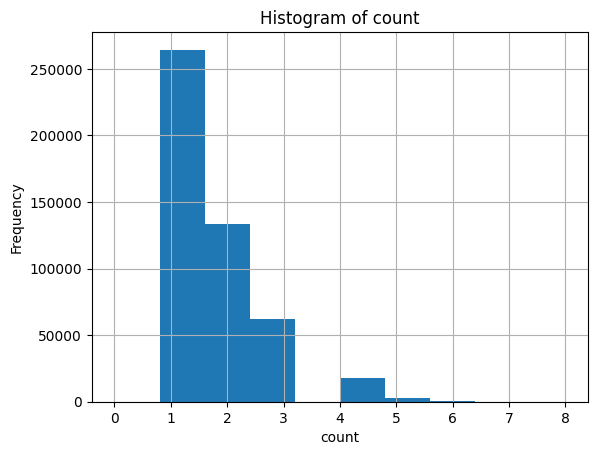

In [9]:
hist_data  = loans_df.toPandas()

hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

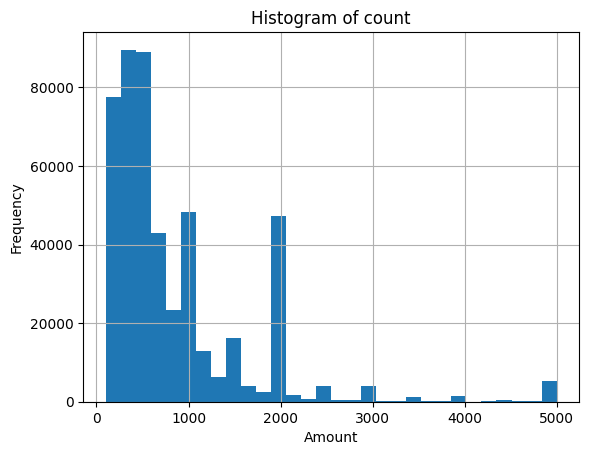

In [10]:
hist_data['Amount'].hist(bins=30)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

#### Counting the No. of user & No. of Loans & No. of Explicitely Created Loan Id (Clustered Loan Id's)

In [11]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('Cluster_result').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 38
Number of unique Loan Id: 407389


In [12]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

Number of unique users: 59158


#### Values of count(Rating) Column.

In [13]:
print('Distinct values of count:')
loans_df.select('count').distinct().orderBy("count").show()

Distinct values of count:
+-----+
|count|
+-----+
|    0|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
+-----+



### Converting the dataset into train validation split.

In [14]:
# we have to use 3 columns or features to put into the ALs Model.
loans_df.select(["Cluster_result","count","Amount"]).show(10)

+--------------+-----+------+
|Cluster_result|count|Amount|
+--------------+-----+------+
|             1|    1|   150|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   150|
|             1|    1|   100|
|             1|    1|   100|
|             1|    1|   100|
+--------------+-----+------+
only showing top 10 rows



In [15]:
train, validation = loans_df.randomSplit([0.8, 0.2])
train.cache()
validation.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, Cluster_result: int]

In [16]:
validation.select(["userId","loanId","Cluster_result","count","Amount","Total_Repayments__c"]).show()

+------+------+--------------+-----+------+-------------------+
|userId|loanId|Cluster_result|count|Amount|Total_Repayments__c|
+------+------+--------------+-----+------+-------------------+
| 24365|     2|             3|    3|   250|                  4|
| 24423|    61|             2|    1|   200|                  2|
|   171|    63|             5|    2|   350|                  3|
|   181|    81|             2|    3|   200|                  5|
|     5|   110|             3|    2|   250|                  5|
| 23566|   125|             3|    1|   250|                 10|
|    21|   153|             5|    2|   350|                  4|
|    25|   160|             4|    1|   300|                  4|
|    27|   164|             5|    1|   350|                  4|
| 24541|   179|             4|    2|   300|                  2|
|    34|   186|             3|    4|   250|                  2|
| 23640|   189|             2|    1|   200|                  5|
| 25421|   193|             2|    3|   2

In [17]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)



In [18]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='Cluster_result', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)

            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)

            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [19]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.027291810100999098
8 latent factors and regularization = 0.01: validation RMSE is 0.06829386905299778
8 latent factors and regularization = 0.05: validation RMSE is 0.0902678242570907
8 latent factors and regularization = 0.1: validation RMSE is 0.11052060736249794
8 latent factors and regularization = 0.2: validation RMSE is 0.2004820884010486
10 latent factors and regularization = 0.001: validation RMSE is 0.05003836269635477
10 latent factors and regularization = 0.01: validation RMSE is 0.06451790281904692
10 latent factors and regularization = 0.05: validation RMSE is 0.07809885908882634
10 latent factors and regularization = 0.1: validation RMSE is 0.10094090525227799
10 latent factors and regularization = 0.2: validation RMSE is 0.19997559922912145
20 latent factors and regularization = 0.001: validation RMSE is 0.13273193256128804
20 latent factors and regularization = 0.01: validation RMSE is 0.04521670096673134

## Predicting the results from validation data

In [20]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [21]:
predictions.filter(predictions.userId == 10).select("userId", "loanId", "count", "Cluster_result", "prediction").show(20)

+------+------+-----+--------------+----------+
|userId|loanId|count|Cluster_result|prediction|
+------+------+-----+--------------+----------+
|    10|106872|    4|             5| 3.9454827|
|    10| 12340|    4|             6| 3.9418194|
|    10| 17247|    4|             6| 3.9418194|
|    10| 53184|    4|             8| 3.9318826|
|    10| 81289|    4|             8| 3.9318826|
+------+------+-----+--------------+----------+



## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [22]:
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))

Root Mean Squared Error (RMSE) = 0.027291810100999098


## Recommendation of N users

In [23]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [24]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Cluster_result: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [25]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- Cluster_result: integer (nullable = true)



In [26]:
validation.count()

95763

## ALS Model Evaluation

In [27]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['userId', 'Cluster_result'], 'inner')

In [28]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('userId').agg(expr('count(Cluster_result) as true_positives'))

In [29]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('userId').agg(expr('count(Cluster_result) as relevant'))

In [30]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as precision')

In [31]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as recall')

In [32]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'userId', 'inner') \
    .selectExpr('userId', '(2 * precision * recall) / (precision + recall) as f1_score')

In [33]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [34]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 1.2830755096902888
Overall Recall: 1.2830755096902888
Overall F1-score: 1.2830755096902802


In [35]:
evaluator = RegressionEvaluator(metricName="mae", labelCol="count", predictionCol="prediction")
mae = evaluator.evaluate(predictions)

In [36]:
"The Mean Absolute Error is :",mae

('The Mean Absolute Error is :', 0.021920923672114175)

## User Factors and Item Factors to calculate the cosine Similarity

In [37]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [38]:
print(userFactors.count())
print("Priting the Schema of userFactors",userFactors.printSchema())

58809
root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

Priting the Schema of userFactors None


In [93]:

userFactors.filter(userFactors.id == 43 ).collect()

[Row(id=43, features=[0.7725750803947449, 0.9910363554954529, 0.18550951778888702, 1.2600431442260742, 0.22888483107089996, 2.6211564540863037, 1.542779564857483, 0.33505648374557495])]

In [58]:
itemFactors.select("id","features").show(10,truncate=False)

+---+-----------------------------------------------------------------------------------------------------+
|id |features                                                                                             |
+---+-----------------------------------------------------------------------------------------------------+
|10 |[0.060640376, 0.07379613, 0.01645249, 0.09126509, 0.0014382865, 0.21174338, 0.12290682, 0.02415844]  |
|20 |[0.06366401, 0.071771264, 0.016012935, 0.09130068, 0.010460623, 0.21190561, 0.12123302, 0.02319845]  |
|30 |[0.05712997, 0.07172645, 0.01472184, 0.09875775, 0.020301528, 0.20809855, 0.12107107, 0.026115062]   |
|1  |[0.07624056, 0.059839588, 0.54002213, 0.12337257, 0.033788886, 0.19642247, 0.108981125, 0.0]         |
|11 |[0.067305624, 0.07565757, 0.015690058, 0.08738142, 0.0030882107, 0.21201986, 0.1217782, 0.02304225]  |
|21 |[0.062449407, 0.07190183, 0.016465226, 0.093305565, 0.010106376, 0.21113224, 0.12083635, 0.02470574] |
|31 |[0.29899782, 0.06675568

## Calculate cosine similarity:

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [59]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

### user-User Cosine Similarity code

In [60]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 10 and 20: 0.9990678087622747


### User-Item Cosine Similarity code

In [61]:
# Example usage
user1_id = 10
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")

Cosine similarity between users 10 and 1: 0.5031378635422614


###  Cosine Similarity of user 10 with all Loans

In [62]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [63]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 10, 'LoanId': 4, 'CosineSimilarity': 0.9997594178089819},
 {'userID': 10, 'LoanId': 6, 'CosineSimilarity': 0.9995120962462724},
 {'userID': 10, 'LoanId': 2, 'CosineSimilarity': 0.999288909342322},
 {'userID': 10, 'LoanId': 25, 'CosineSimilarity': 0.9992548057720446},
 {'userID': 10, 'LoanId': 9, 'CosineSimilarity': 0.9991152743422744},
 {'userID': 10, 'LoanId': 8, 'CosineSimilarity': 0.9990678089742598},
 {'userID': 10, 'LoanId': 7, 'CosineSimilarity': 0.9990063766583603},
 {'userID': 10, 'LoanId': 10, 'CosineSimilarity': 0.9989919988014851},
 {'userID': 10, 'LoanId': 5, 'CosineSimilarity': 0.9988329206582994},
 {'userID': 10, 'LoanId': 12, 'CosineSimilarity': 0.9988216993271013},
 {'userID': 10, 'LoanId': 16, 'CosineSimilarity': 0.998738497142623},
 {'userID': 10, 'LoanId': 14, 'CosineSimilarity': 0.9985519832806705},
 {'userID': 10, 'LoanId': 13, 'CosineSimilarity': 0.9983750418158638},
 {'userID': 10, 'LoanId': 11, 'CosineSimilarity': 0.998195856965576},
 {'userID': 10, 

### Cosine Similarity of all users with all loans

In [64]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [65]:
# Initially the code is like this !!
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

def cosine_similarity(vec1, vec2):
    dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
    magnitude1 = sum(v ** 2 for v in vec1) ** 0.5
    magnitude2 = sum(v ** 2 for v in vec2) ** 0.5
    return dot_product / (magnitude1 * magnitude2)

In [66]:


# Initialize list to store recommendations
CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.0035649245977401735 hours


In [67]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [68]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [21, 13, 20, 18, 16]},
 {'userId': 2, 'Recommendation': [10, 12, 25, 14, 16]},
 {'userId': 3, 'Recommendation': [25, 10, 12, 6, 7]},
 {'userId': 4, 'Recommendation': [2, 4, 6, 9, 25]},
 {'userId': 5, 'Recommendation': [25, 10, 8, 12, 6]},
 {'userId': 6, 'Recommendation': [12, 10, 16, 14, 25]},
 {'userId': 7, 'Recommendation': [10, 25, 12, 7, 6]},
 {'userId': 8, 'Recommendation': [21, 13, 16, 14, 20]},
 {'userId': 9, 'Recommendation': [6, 7, 10, 25, 5]},
 {'userId': 10, 'Recommendation': [4, 6, 2, 25, 9]},
 {'userId': 11, 'Recommendation': [4, 6, 25, 10, 7]},
 {'userId': 12, 'Recommendation': [25, 16, 14, 10, 12]},
 {'userId': 13, 'Recommendation': [8, 25, 10, 6, 12]},
 {'userId': 14, 'Recommendation': [21, 16, 13, 14, 15]},
 {'userId': 15, 'Recommendation': [4, 6, 25, 2, 7]},
 {'userId': 16, 'Recommendation': [16, 14, 12, 13, 25]},
 {'userId': 17, 'Recommendation': [6, 25, 4, 10, 7]},
 {'userId': 18, 'Recommendation': [8, 10, 25, 12, 7]},
 {'userId': 19

In [69]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [71]:
recommendations_for_users

[{'UserId': 1, 'Recommendations': [13, 20, 23, 19, 22]},
 {'UserId': 2, 'Recommendations': [12, 14, 15, 7, 21]},
 {'UserId': 3, 'Recommendations': [12, 7, 16, 14, 13]},
 {'UserId': 4, 'Recommendations': [6, 9, 25, 5, 7]},
 {'UserId': 5, 'Recommendations': [25, 12, 7, 14, 13]},
 {'UserId': 6, 'Recommendations': [10, 14, 25, 13, 15]},
 {'UserId': 7, 'Recommendations': [10, 7, 14, 8, 13]},
 {'UserId': 8, 'Recommendations': [14, 19, 23, 17, 22]},
 {'UserId': 9, 'Recommendations': [10, 25, 5, 12, 4]},
 {'UserId': 10, 'Recommendations': [9, 7, 10, 16, 14]},
 {'UserId': 11, 'Recommendations': [25, 7, 9, 5, 13]},
 {'UserId': 12, 'Recommendations': [25, 10, 12, 13, 15]},
 {'UserId': 13, 'Recommendations': [10, 12, 7, 16, 14]},
 {'UserId': 14, 'Recommendations': [13, 14, 15, 20, 18]},
 {'UserId': 15, 'Recommendations': [7, 9, 12, 16, 14]},
 {'UserId': 16, 'Recommendations': [14, 13, 10, 15, 21]},
 {'UserId': 17, 'Recommendations': [25, 7, 14, 13, 9]},
 {'UserId': 18, 'Recommendations': [10, 25, 

In [72]:
userRecommends.select(["userId","recommendations.Cluster_result","recommendations.rating"]).show(10,truncate=False)

+------+---------------+----------------------------------------------------------+
|userId|Cluster_result |rating                                                    |
+------+---------------+----------------------------------------------------------+
|1     |[1, 5, 2, 4, 6]|[3.1973941, 2.9754426, 2.973622, 2.9732902, 2.9721944]    |
|6     |[1, 5, 2, 4, 6]|[1.0708739, 0.99103683, 0.9909493, 0.9904757, 0.98997426] |
|12    |[1, 3, 2, 5, 4]|[2.1357608, 1.9834636, 1.9821872, 1.98141, 1.9804958]     |
|13    |[1, 3, 2, 5, 4]|[1.0678552, 0.9914314, 0.9903309, 0.98941994, 0.9891567]  |
|16    |[1, 5, 2, 4, 6]|[1.067719, 0.9914297, 0.99141026, 0.990965, 0.99046445]   |
|22    |[1, 3, 2, 5, 4]|[1.075126, 0.99630827, 0.985632, 0.98390496, 0.98322177]  |
|26    |[1, 5, 2, 4, 6]|[1.0689243, 0.9908544, 0.99049705, 0.99009454, 0.98965096]|
|27    |[1, 3, 2, 4, 5]|[1.0532255, 0.993808, 0.9893897, 0.98748857, 0.98745155]  |
|28    |[1, 5, 2, 4, 6]|[1.0684443, 0.99052495, 0.99040747, 0.9898506, 0.989

In [73]:
actual = [listo for listo in actual_loans_taken_dict.values()]

In [74]:
predicted = [listo['Recommendation'] for listo in top_n_recommendations]

In [75]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [76]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.2007


In [106]:
k = 3
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@3: 0.2090


In [77]:
userRecomd = userRecommends.select("recommendations.Cluster_result").collect() #.show(10,truncate=False)

In [78]:
ALsRecomd = [elemt.asDict()['Cluster_result'] for elemt in userRecomd]

In [79]:

k = 5
map_at_5 = map_at_k(actual, ALsRecomd, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.1339


##  Calculate centered cosine similarity:

In [67]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [68]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9958091259308894


### User-Item Centerd Cosine Similarity code

In [69]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9846653141373279


### Centered Cosine Similarity of user 10 with all Loans

In [70]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [71]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 25, 'CenteredSimilarity': 0.9883251622950934},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

In [72]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9846653141373279},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9993435123150312},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.9999751517477451},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9996252399081585},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9993524436452954},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9961854650889006},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9968689838562832},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9958091262067013},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9921921103738105},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9860440617410834},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9872106949357707},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9850307062957183},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.9817486250975127},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.981785

## Cosine Similarity of all users with all loans

In [73]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [74]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim

In [75]:
# Initialize list to store recommendations
Centered_CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        Centered_CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.006168066263198852 hours


In [76]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_Centered_recommendations = extract_top_n_recommendations(Centered_CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [77]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in Centered_CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



In [78]:
def average_precision_at_k(actual, predicted, k):
    # Initialize variables
    num_hits = 0
    precision_at_k = 0.0

    # Iterate over the predicted list up to k
    for i, p in enumerate(predicted[:k]):
        # Check if the predicted item at position i is in the actual list
        if p in actual:
            num_hits += 1
            # Calculate precision at position i
            precision_at_k += num_hits / (i + 1)

    # Calculate average precision at k
    if not actual:
        return 0.0
    else:
        return precision_at_k / min(len(actual), k)

def map_at_k(actual, predicted, k):
    # Calculate average precision at k for each query or user
    average_precisions = [average_precision_at_k(a, p, k) for a, p in zip(actual, predicted)]
    
    # Return the mean of average precision at k values
    return sum(average_precisions) / len(average_precisions)

In [79]:
actual = [listo for listo in actual_loans_taken_dict.values()]
predicted = [listo['Recommendation'] for listo in top_n_Centered_recommendations]

In [80]:

k = 5
map_at_5 = map_at_k(actual, predicted, k)
print("MAP@{}: {:.4f}".format(k, map_at_5))

MAP@5: 0.1867
